In [1]:
import numpy as np
import tables
import sys
sys.path.append('/Users/eframe/dmi/src')
import calibrate as calib
import eventAnalysis as ea
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.font_manager import FontProperties
import math 

In [2]:
NUMCH = 38
def inge1(dets):
    """Checks if strip numbers in det array are in detector 1
    """
    return [(dets < NUMCH) | ((dets >= NUMCH*2)&(dets < NUMCH*3)) ]

def inge2(dets):
    """Checks if strip numbers in det array are in detector 2
    """
    return [((dets >= 1*NUMCH)&(dets < 2*NUMCH)) | (dets >= NUMCH*3) ]

In [3]:
def gauss(x, h, mu, sig):
    """ Gaussian function
    """
    return h*np.exp(-0.5*((x-mu)/sig)**2)

In [5]:
# Loading Source Data
fam1 = tables.open_file( '/Users/eframe/dmi/data/energyres/am1.h5', 'r' )
fam2 = tables.open_file( '/Users/eframe/dmi/data/energyres/am2.h5', 'r' )
fba1 = tables.open_file( '/Users/eframe/dmi/data/energyres/ba1.h5', 'r' )
fba2 = tables.open_file( '/Users/eframe/dmi/data/energyres/ba2.h5', 'r' )
fcs1 = tables.open_file( '/Users/eframe/dmi/data/energyres/cs1.h5', 'r' )
fcs2 = tables.open_file( '/Users/eframe/dmi/data/energyres/cs2.h5', 'r' )
fco571 = tables.open_file( '/Users/eframe/dmi/data/energyres/co57_1.h5', 'r' )
fco572 = tables.open_file( '/Users/eframe/dmi/data/energyres/co57_2.h5', 'r' )
fco601 = tables.open_file( '/Users/eframe/dmi/data/energyres/co60_1.h5', 'r' )
fco602 = tables.open_file( '/Users/eframe/dmi/data/energyres/co60_2.h5', 'r' )

unrecon = np.concatenate( ( fam1.root.EventData.read(), fam2.root.EventData.read(),
                       fba1.root.EventData.read(), fba2.root.EventData.read(),
                       fcs1.root.EventData.read(), fcs2.root.EventData.read(), 
                       fco571.root.EventData.read(), fco572.root.EventData.read(),
                       fco601.root.EventData.read(), fco602.root.EventData.read() ) )

singles = np.concatenate( ( fam1.root.Interactions.Single.read(), fam2.root.Interactions.Single.read(),
                       fba1.root.Interactions.Single.read(), fba2.root.Interactions.Single.read(),
                       fcs1.root.Interactions.Single.read(), fcs2.root.Interactions.Single.read(), 
                       fco571.root.Interactions.Single.read(), fco572.root.Interactions.Single.read(),
                       fco601.root.Interactions.Single.read(), fco602.root.Interactions.Single.read() ) )

doubles = np.concatenate( ( fam1.root.Interactions.Double.read(), fam2.root.Interactions.Double.read(),
                       fba1.root.Interactions.Double.read(), fba2.root.Interactions.Double.read(),
                       fcs1.root.Interactions.Double.read(), fcs2.root.Interactions.Double.read(), 
                       fco571.root.Interactions.Double.read(), fco572.root.Interactions.Double.read(),
                       fco601.root.Interactions.Double.read(), fco602.root.Interactions.Double.read() ) )

doubles = doubles.reshape( int ( len ( doubles ) / 2 ), 2 )

detector = unrecon[ 'detector' ]
energy = unrecon[ 'ADC_value' ]
singles_energy = singles['energy']
doubles_energy = doubles['energy'].sum(axis=1)

In [6]:
hist_sing, be_sing = np.histogram( singles_energy, bins = 1500, range = ( 10, 1500 ) )
bins_sing = calib.bin_centers( be_sing )
hist_doub, be_doub = np.histogram( doubles_energy, bins = 1500, range = ( 10, 1500 ) )
bins_doub = calib.bin_centers( be_doub )

bins = bins_doub.copy()
hist = hist_doub.copy()
maskam = ( bins > 50 ) & ( bins < 70 )
maskba1 = ( bins > 70 ) & ( bins < 90 )
maskco57 = ( bins > 110 ) & ( bins < 130 )
maskba2 = ( bins > 350 ) & ( bins < 370 )
maskcs = ( bins > 640 ) & ( bins < 690 )
maskco601 = ( bins > 1150 ) & ( bins < 1190 )
maskco602 = ( bins > 1310 ) & ( bins < 1360 )

bline_am = ( np.mean( hist[maskam][:5] ) + np.mean( hist[maskam][-5:] ) ) / 2
bline_ba1 = ( np.mean( hist[maskba1][:5] ) + np.mean( hist[maskba1][-5:] ) ) / 2
bline_ba2 = ( np.mean( hist[maskba2][:5] ) + np.mean( hist[maskba2][-5:] ) ) / 2
bline_cs = ( np.mean( hist[maskcs][:5] ) + np.mean( hist[maskcs][-5:] ) ) / 2
bline_co57 = ( np.mean( hist[maskco57][:5] ) + np.mean( hist[maskco57][-5:] ) ) / 2
bline_co601 = ( np.mean( hist[maskco601][:5] ) + np.mean( hist[maskco601][-5:] ) ) / 2
bline_co602 = ( np.mean( hist[maskco602][:5] ) + np.mean( hist[maskco602][-5:] ) ) / 2

popt_am, pcov_am = curve_fit( gauss, bins[maskam], hist[maskam] - bline_am, 
                             p0 = [ max(hist[maskam] - bline_am), 
                                        bins[maskam][np.argmax(hist[maskam])], 1.5 ] )

popt_ba1, pcov_ba1 = curve_fit( gauss, bins[maskba1], hist[maskba1] - bline_ba1, 
                         p0 = [ max(hist[maskba1] - bline_ba1), 
                                    bins[maskba1][np.argmax(hist[maskba1])], 1.5 ] )

popt_ba2, pcov_ba2 = curve_fit( gauss, bins[maskba2], hist[maskba2] - bline_ba2, 
                     p0 = [ max(hist[maskba2] - bline_ba2), 
                                bins[maskba2][np.argmax(hist[maskba2])], 1.5 ] )

popt_co57, pcov_co57 = curve_fit( gauss, bins[maskco57], hist[maskco57] - bline_co57, 
                     p0 = [ max(hist[maskco57] - bline_co57), 
                                bins[maskco57][np.argmax(hist[maskco57])], 1.5 ] )

popt_cs, pcov_cs = curve_fit( gauss, bins[maskcs], hist[maskcs] - bline_cs, 
                             p0 = [ max(hist[maskcs] - bline_cs), 
                                        bins[maskcs][np.argmax(hist[maskcs])], 1.5 ] )

popt_co601, pcov_co601 = curve_fit( gauss, bins[maskco601], hist[maskco601] - bline_co601, 
                 p0 = [ max(hist[maskco601] - bline_co601), 
                            bins[maskco601][np.argmax(hist[maskco601])], 2 ] )

popt_co602, pcov_co602 = curve_fit( gauss, bins[maskco602], hist[maskco602] - bline_co602, 
             p0 = [ max(hist[maskco602] - bline_co602), 
                        bins[maskco602][np.argmax(hist[maskco602])], 2 ] )

err_am = np.sqrt(np.diag(pcov_am))[2] * popt_am[2] * 2.36
err_ba1 = np.sqrt(np.diag(pcov_ba1))[2] * popt_ba1[2] * 2.36
err_ba2 = np.sqrt(np.diag(pcov_ba2))[2] * popt_ba2[2] * 2.36
err_co57 = np.sqrt(np.diag(pcov_co57))[2] * popt_co57[2] * 2.36
err_cs = np.sqrt(np.diag(pcov_cs))[2] * popt_cs[2] * 2.36
err_co601 = np.sqrt(np.diag(pcov_co601))[2] * popt_co601[2] * 2.36
err_co602 = np.sqrt(np.diag(pcov_co602))[2] * popt_co602[2] * 2.36

print( popt_am[2] * 2.36, err_am,  popt_am[2] * 2.36/60*100)
print( popt_ba1[2]* 2.36, err_ba1, popt_ba1[2]* 2.36/81*100 )
print( popt_co57[2] * 2.36, err_co57, popt_co57[2] * 2.36/122*100 )
print( popt_ba2[2] * 2.36, err_ba2, popt_ba2[2] * 2.36/356*100 )
print( popt_cs[2] * 2.36, err_cs, popt_cs[2] * 2.36/662*100 )
print( popt_co601[2] * 2.36, err_co601, popt_co601[2] * 2.36/1173*100 )
print( popt_co602[2] * 2.36, err_co602, popt_co602[2] * 2.36/1332*100 )

3.54 inf 5.9
11.800353632373255 336.39155572730107 14.568337817744759
10.902035102778491 25.932810593021767 8.936094346539747
2.747963974541607 0.051926102130672384 0.771899992848766
3.2422934075435856 0.07264317617807597 0.4897724180579434
4.125925213545241 0.1546749384982183 0.3517412799271305
4.555236906470498 0.19251209265687963 0.3419847527380253


/Users/eframe/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [7]:
hist, be = np.histogram( energy, bins = 1500, range = ( 10, 1500 ) )
bins = calib.bin_centers( be )

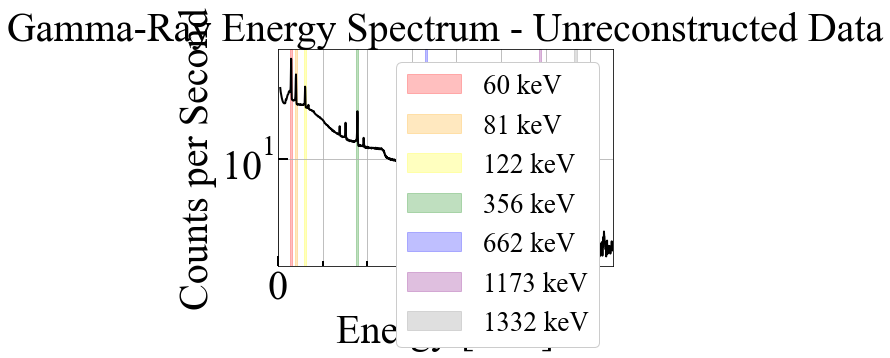

In [8]:
%matplotlib inline
font = FontProperties()
font.set_name('Times New Roman')
fig, ax = plt.subplots()
ax.set_xlabel('Energy [keV]', fontsize=40, fontproperties=font, labelpad=5)
ax.set_ylabel('Counts per Second', fontsize=40, fontproperties=font)
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=2, direction='in', labelsize=40)
ax.tick_params(which='minor', length=5, width=2, direction='in')
ax.set_title('Gamma-Ray Energy Spectrum - Unreconstructed Data', fontsize=40, fontproperties=font)
ax.set_xlim(0, 1500)

ax.semilogy( bins, hist/300, 'k', linewidth=2)
ax.axvspan(55, 62,  alpha=0.25, color = 'red', label="60 keV")
ax.axvspan(77, 84,  alpha=0.25, color = 'orange', label="81 keV")
ax.axvspan(118, 125,  alpha=0.25, color = 'yellow', label="122 keV")
ax.axvspan(352, 360,  alpha=0.25, color = 'green', label="356 keV")
ax.axvspan(658, 666,  alpha=0.25, color = 'blue', label="662 keV")
ax.axvspan(1168, 1178,  alpha=0.25, color = 'purple', label="1173 keV")
ax.axvspan(1326, 1338,  alpha=0.25, color = 'grey', label="1332 keV")

# ax.semilogy( bins_sing, hist_sing/300, linewidth=2, label=r'Single-Interaction Events')
# ax.semilogy( bins_doub, hist_doub/300, linewidth=2, label=r'Double-Interaction Events')

ax.legend(prop={"family":"Times New Roman", 'size': 27}, ncol=1, 
          loc='upper right', framealpha=1)

ax.grid(which='both')
for l in ax.xaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40)
for l in ax.yaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40) 
plt.show()

In [21]:
# Finding Peaks of Gamma-ray Lines for Calibration
%matplotlib inline
fwhm_am, fwhm_ba1, fwhm_ba2, fwhm_cs, fwhm_co57, fwhm_co601, fwhm_co602 = [], [], [], [], [], [], []
for s in np.arange( 0, 152, 1 ):
    mask = ( detector == s )
    hist, be = np.histogram( energy[mask], bins = 1500, range = ( 10, 1500 ) )
    bins = calib.bin_centers( be )
    maskam = ( bins > 50 ) & ( bins < 70 )
    maskba1 = ( bins > 70 ) & ( bins < 90 )
    maskco57 = ( bins > 110 ) & ( bins < 130 )
    maskba2 = ( bins > 350 ) & ( bins < 370 )
    maskcs = ( bins > 640 ) & ( bins < 690 )
    maskco601 = ( bins > 1150 ) & ( bins < 1190 )
    maskco602 = ( bins > 1310 ) & ( bins < 1360 )
    
    bline_am = ( np.mean( hist[maskam][:5] ) + np.mean( hist[maskam][-5:] ) ) / 2
    bline_ba1 = ( np.mean( hist[maskba1][:5] ) + np.mean( hist[maskba1][-5:] ) ) / 2
    bline_ba2 = ( np.mean( hist[maskba2][:5] ) + np.mean( hist[maskba2][-5:] ) ) / 2
    bline_cs = ( np.mean( hist[maskcs][:5] ) + np.mean( hist[maskcs][-5:] ) ) / 2
    bline_co57 = ( np.mean( hist[maskco57][:5] ) + np.mean( hist[maskco57][-5:] ) ) / 2
    bline_co601 = ( np.mean( hist[maskco601][:5] ) + np.mean( hist[maskco601][-5:] ) ) / 2
    bline_co602 = ( np.mean( hist[maskco602][:5] ) + np.mean( hist[maskco602][-5:] ) ) / 2
    
    popt_am, pcov_am = curve_fit( gauss, bins[maskam], hist[maskam] - bline_am, 
                                 p0 = [ max(hist[maskam] - bline_am), 
                                            bins[maskam][np.argmax(hist[maskam])], 1.5 ] )
    
    popt_ba1, pcov_ba1 = curve_fit( gauss, bins[maskba1], hist[maskba1] - bline_ba1, 
                             p0 = [ max(hist[maskba1] - bline_ba1), 
                                        bins[maskba1][np.argmax(hist[maskba1])], 1.5 ] )
    
    popt_ba2, pcov_ba2 = curve_fit( gauss, bins[maskba2], hist[maskba2] - bline_ba2, 
                         p0 = [ max(hist[maskba2] - bline_ba2), 
                                    bins[maskba2][np.argmax(hist[maskba2])], 1.5 ] )
    
    popt_co57, pcov_co57 = curve_fit( gauss, bins[maskco57], hist[maskco57] - bline_co57, 
                         p0 = [ max(hist[maskco57] - bline_co57), 
                                    bins[maskco57][np.argmax(hist[maskco57])], 1.5 ] )
        
    popt_cs, pcov_cs = curve_fit( gauss, bins[maskcs], hist[maskcs] - bline_cs, 
                                 p0 = [ max(hist[maskcs] - bline_cs), 
                                            bins[maskcs][np.argmax(hist[maskcs])], 1.5 ] )
    
    popt_co601, pcov_co601 = curve_fit( gauss, bins[maskco601], hist[maskco601] - bline_co601, 
                     p0 = [ max(hist[maskco601] - bline_co601), 
                                bins[maskco601][np.argmax(hist[maskco601])], 2 ] )
    
    popt_co602, pcov_co602 = curve_fit( gauss, bins[maskco602], hist[maskco602] - bline_co602, 
                 p0 = [ max(hist[maskco602] - bline_co602), 
                            bins[maskco602][np.argmax(hist[maskco602])], 2 ] )
    
    gauss_curve = gauss( np.arange( min(bins[maskcs]), max(bins[maskcs]), 0.1 ), 
                        popt_cs[0], popt_cs[1], popt_cs[2] ) + bline_cs

    fwhm_am.append( [ popt_am[2] * 2.36, np.sqrt(np.diag(pcov_am))[2] * popt_am[2] * 2.36  ] )
    fwhm_ba1.append( [ popt_ba1[2] * 2.36, np.sqrt(np.diag(pcov_ba1))[2] * popt_ba1[2] * 2.36 ] )
    fwhm_ba2.append( [ popt_ba2[2] * 2.36, np.sqrt(np.diag(pcov_ba2))[2] * popt_ba2[2] * 2.36 ] )
    fwhm_co57.append( [ popt_co57[2] * 2.36, np.sqrt(np.diag(pcov_co57))[2] * popt_co57[2] * 2.36 ] )
    fwhm_cs.append( [ popt_cs[2] * 2.36, np.sqrt(np.diag(pcov_cs))[2] * popt_cs[2] * 2.36 ] )
    fwhm_co601.append( [ popt_co601[2] * 2.36, np.sqrt(np.diag(pcov_co601))[2] * popt_co601[2] * 2.36 ] )
    fwhm_co602.append( [ popt_co602[2] * 2.36, np.sqrt(np.diag(pcov_co602))[2] * popt_co602[2] * 2.36] )
    
print( popt_cs[2] *2.36 )

/Users/eframe/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


3.3114520825942075


In [22]:
fwhm_cs

[[3.54, inf],
 [3.54, inf],
 [3.54, inf],
 [4.5990460463781595, 0.7982876006166896],
 [2.1543127333829313, 0.12766254481107456],
 [3.1192042731157916, 0.2307661664780663],
 [2.512303321806866, 0.15733567861812306],
 [2.6998530390649425, 0.2048249063692651],
 [2.6361460209866383, 0.24988855190825898],
 [2.5759512000902447, 0.1920432185106445],
 [2.6446016223257587, 0.210781933732056],
 [2.321802771728586, 0.20836464390018292],
 [2.509284369690966, 0.17263604429857185],
 [2.418777871687046, 0.18477961326530815],
 [2.8619275991680446, 0.2655947603488978],
 [2.5800075075159534, 0.17792842951477528],
 [2.59984261941041, 0.22162324176164994],
 [2.7977046177435105, 0.2310647208781452],
 [2.6240004178568217, 0.22233090816200599],
 [2.206018469402996, 0.1338144292627167],
 [2.362346575393345, 0.16543934828931287],
 [2.8686918519843823, 0.20610496373626674],
 [2.4847823400405202, 0.15407438636091342],
 [2.396602371323196, 0.14394552532243857],
 [2.1643443217535174, 0.14588677275195833],
 [2.5217

In [25]:
fwhm_am = np.array( fwhm_am )
fwhm_ba1 = np.array( fwhm_ba1 ) 
fwhm_ba2 = np.array( fwhm_ba2 )
fwhm_co57 = np.array( fwhm_co57 )
fwhm_cs = np.array( fwhm_cs )
fwhm_co601 = np.array( fwhm_co601 )
fwhm_co602 = np.array( fwhm_co602 ) 

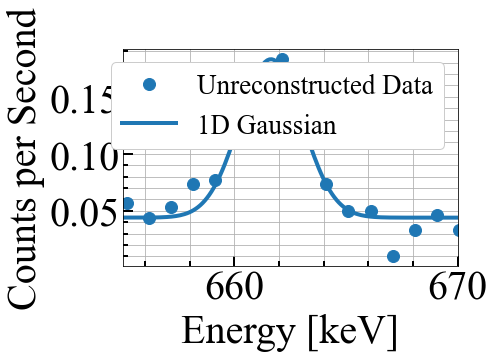

In [26]:
%matplotlib inline
font = FontProperties()
font.set_name('Times New Roman')
fig, ax = plt.subplots()
ax.set_xlabel('Energy [keV]', fontsize=40, fontproperties=font, labelpad=5)
ax.set_ylabel('Counts per Second', fontsize=40, fontproperties=font)
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=2, direction='in', labelsize=40)
ax.tick_params(which='minor', length=5, width=2, direction='in')

ax.plot( bins[maskcs], hist[maskcs]/300, 'o', color= 'tab:blue', markersize=12, label=r'Unreconstructed Data')

ax.plot( np.arange( min(bins[maskcs]), max(bins[maskcs]), 0.1 ), 
        gauss_curve/300, '-', color= 'tab:blue', linewidth = 4, label='1D Gaussian')

ax.legend(prop={"family":"Times New Roman", 'size': 27}, ncol=1, 
          loc='upper right', framealpha=1)
ax.set_xlim(655, 670)
ax.grid(which='both')
for l in ax.xaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40)
for l in ax.yaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40) 
plt.show()

In [35]:
fwhm = fwhm_cs.copy()
E, n = 1, 1
mask = ( np.isinf( fwhm[:, 1] )  ) | ( fwhm[:, 1] > 5 )
fwhm = fwhm[ ~mask ]
# maskd1 = inge1(np.arange(0, 152)[~mask])
# maskd2 = inge2(np.arange(0, 152)[~mask])
# idx1 = np.argmin( fwhm[maskd1][:, 0] )
# idx2 = np.argmin( fwhm[maskd2][:, 0] )
# print( np.mean(fwhm[maskd1][:, 0] )/E*n, np.mean( fwhm[maskd1][:, 1] )/E*n, \
#       np.min(fwhm[maskd1][:, 0] )/E*n, fwhm[maskd1][idx1, 1]/E *n )
# print( np.mean(fwhm[maskd2][:, 0]/E*n ), np.mean( fwhm[maskd2][:, 1] )/E*n, \
#       np.min(fwhm[maskd2][:, 0] )/E*n, fwhm[maskd2][idx2, 1]/E*n ) 

In [36]:
fwhm

array([[4.59904605, 0.7982876 ],
       [2.15431273, 0.12766254],
       [3.11920427, 0.23076617],
       [2.51230332, 0.15733568],
       [2.69985304, 0.20482491],
       [2.63614602, 0.24988855],
       [2.5759512 , 0.19204322],
       [2.64460162, 0.21078193],
       [2.32180277, 0.20836464],
       [2.50928437, 0.17263604],
       [2.41877787, 0.18477961],
       [2.8619276 , 0.26559476],
       [2.58000751, 0.17792843],
       [2.59984262, 0.22162324],
       [2.79770462, 0.23106472],
       [2.62400042, 0.22233091],
       [2.20601847, 0.13381443],
       [2.36234658, 0.16543935],
       [2.86869185, 0.20610496],
       [2.48478234, 0.15407439],
       [2.39660237, 0.14394553],
       [2.16434432, 0.14588677],
       [2.52174602, 0.17448742],
       [2.37089398, 0.15429197],
       [2.58619697, 0.19275729],
       [2.35567493, 0.16310669],
       [2.71861898, 0.18499782],
       [2.21749197, 0.17387575],
       [3.21099674, 0.29844834],
       [2.81883792, 0.24847262],
       [2.

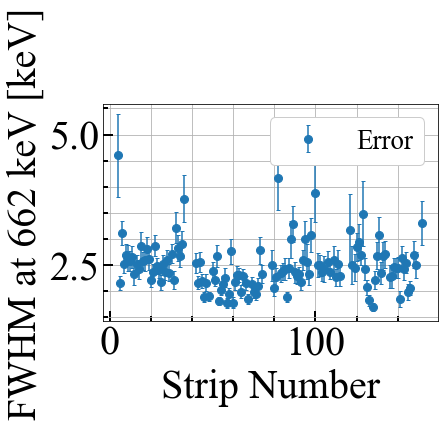

In [37]:
%matplotlib inline
font = FontProperties()
font.set_name('Times New Roman')
fig, ax = plt.subplots()
ax.set_xlabel('Strip Number', fontsize=40, fontproperties=font, labelpad=5)
ax.set_ylabel('FWHM at 662 keV [keV]', fontsize=40, fontproperties=font)
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=2, direction='in', labelsize=40)
ax.tick_params(which='minor', length=5, width=2, direction='in')

ax.errorbar( ( np.arange(0, 152) + 1 )[~mask] , fwhm[:, 0], yerr=fwhm[:, 1], fmt='o', capsize=2, 
            markersize = 8, label='Error')

ax.legend(prop={"family":"Times New Roman", 'size': 27}, ncol=1, 
          loc='upper right', framealpha=1)
ax.grid(which='both')
for l in ax.xaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40)
for l in ax.yaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40) 
plt.show()

In [38]:
mask2 = fwhm[:, 0] > 3

In [39]:
( np.arange(0, 152) + 1 )[~mask][mask2]

array([  4,   6,  32,  36,  82,  89,  98, 100, 117, 123, 131, 152])